In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import pandas as pd
from cuml.manifold.umap import UMAP as cumlUMAP
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### load data

In [3]:
DATASET_ID = 'gibbon_morita_segmented'
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'gibbon_lower.pickle'

In [4]:
syllable_df = pd.read_pickle(df_loc)
del syllable_df['audio']

In [5]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,rate,spectrogram
0,349.04,350.98,UNK,0,20170912-070002_01_ch,16000,"[[5, 5, 5, 17, 11, 10, 14, 14, 8, 10, 10, 13, ..."
1,390.04,391.94,UNK,0,20170912-070002_01_ch,16000,"[[3, 3, 3, 4, 8, 4, 4, 6, 5, 5, 6, 3, 4, 7, 5,..."
2,422.44,425.08,UNK,0,20170912-070002_01_ch,16000,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."


In [6]:
np.shape(syllable_df.spectrogram.values[0])

(32, 34)

### project

In [7]:
specs = list(syllable_df.spectrogram.values)
specs = [i/np.max(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(9220, 1088)

In [8]:
min_dist = 0.5
cuml_umap = cumlUMAP(min_dist = min_dist)
embedding = cuml_umap.fit_transform(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
syllable_df['umap'] = list(embedding)

In [10]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,rate,spectrogram,umap
0,349.04,350.98,UNK,0,20170912-070002_01_ch,16000,"[[5, 5, 5, 17, 11, 10, 14, 14, 8, 10, 10, 13, ...","[-2.7420763969421387, 2.431384563446045]"
1,390.04,391.94,UNK,0,20170912-070002_01_ch,16000,"[[3, 3, 3, 4, 8, 4, 4, 6, 5, 5, 6, 3, 4, 7, 5,...","[-2.375183582305908, 2.694180488586426]"
2,422.44,425.08,UNK,0,20170912-070002_01_ch,16000,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,...","[-1.0474355220794678, 1.8300598859786987]"


(-8, 8)

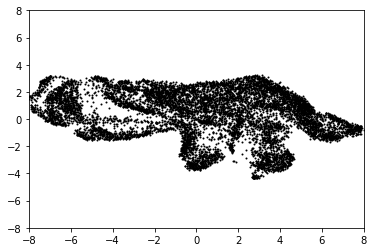

In [11]:
fig, ax = plt.subplots()
ax.scatter(embedding[:,0], embedding[:,1], s=1, color='k', alpha = 1)
ax.set_xlim([-8,8])
ax.set_ylim([-8,8])

### Save

In [12]:
ensure_dir(DATA_DIR / 'embeddings' / DATASET_ID / 'full')

In [13]:
syllable_df.to_pickle(DATA_DIR / 'embeddings' / DATASET_ID / (str(min_dist) + '_full.pickle'))